In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
from diffusers import MarigoldDepthPipeline
from PIL import Image
from transformers import pipeline

assert torch.cuda.is_available(), 'CUDA is not available'

/home/lanter/miniconda3/envs/torch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sample_img_path = 'stuff/driver-illustration/driver.jpg'

In [29]:
output_dir = Path('stuff/driver-illustration')

## Model comparison

### Marigold

In [3]:
MODEL = 'prs-eth/marigold-depth-v1-0'
pipe = MarigoldDepthPipeline.from_pretrained(MODEL, device=0)

Fetching 12 files: 100%|██████████| 12/12 [00:00<00:00, 31.36it/s]
Keyword arguments {'device': 0} are not expected by MarigoldDepthPipeline and will be ignored.
Loading pipeline components...: 100%|██████████| 5/5 [00:00<00:00,  6.62it/s]


In [4]:
image = Image.open(sample_img_path)
res_marigold = pipe(image)

Marigold predictions...: 100%|██████████| 1/1 [00:58<00:00, 58.03s/it]


In [5]:
img = np.array(res_marigold.prediction.data).squeeze()

(-0.5, 799.5, 799.5, -0.5)

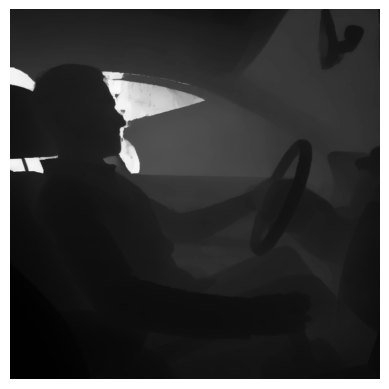

In [7]:
plt.imshow(img, cmap='gray')
plt.axis('off')

(array([258844., 252256.,  93409.,  17525.,    460.,    609.,   1805.,
          3231.,   4731.,   7130.]),
 array([0.        , 0.09987111, 0.19974221, 0.29961333, 0.39948443,
        0.49935552, 0.59922665, 0.69909775, 0.79896885, 0.89883995,
        0.99871105]),
 <BarContainer object of 10 artists>)

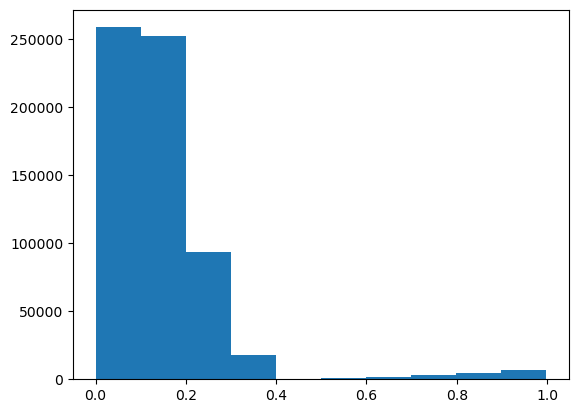

In [6]:
plt.hist(img.flatten())

In [26]:
min_depth = np.min(img)
max_depth = np.max(img)
inverted = max_depth + min_depth - img

In [27]:
inverted = np.clip(inverted, 0.7, 1.0)

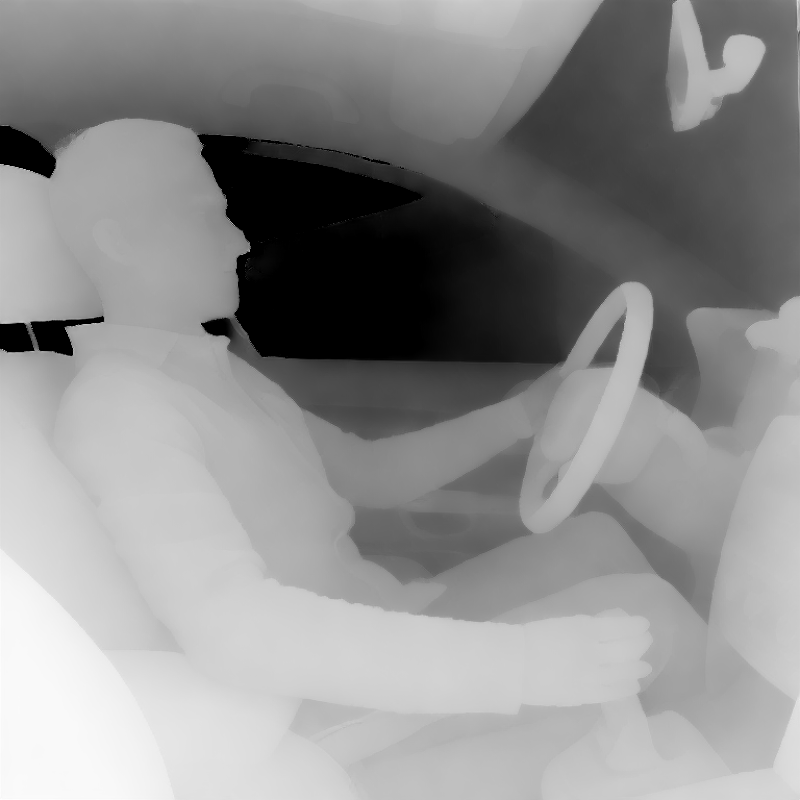

In [28]:
min_depth = np.min(inverted)
max_depth = np.max(inverted)
normalized = (inverted - min_depth) / (max_depth - min_depth)
normalized = (normalized * 255).astype(np.uint8)
normalized = Image.fromarray(normalized)
normalized

In [30]:
normalized.save(output_dir / 'marigold_depth_bw.jpg')

In [53]:
def depth_to_image(
    depth_array: np.ndarray, output_path: str | Path = 'logs/depth_image.png'
) -> Image.Image:
    # Normalize depth values to 0-255
    normalized = (depth_array - np.min(depth_array)) / (
        np.max(depth_array) - np.min(depth_array)
    )
    normalized = (normalized * 255).astype(np.uint8)

    # Apply a colormap for better visualization (optional)
    colormap = plt.cm.Spectral  # type: ignore
    color_mapped = colormap(normalized)
    color_mapped = (color_mapped[:, :, :3] * 255).astype(np.uint8)  # Convert to RGB

    # Save as an image
    image = Image.fromarray(color_mapped)
    image.save(output_path)
    print(f'Image saved to {output_path}')
    return image

Image saved to logs/marigold_depth.png


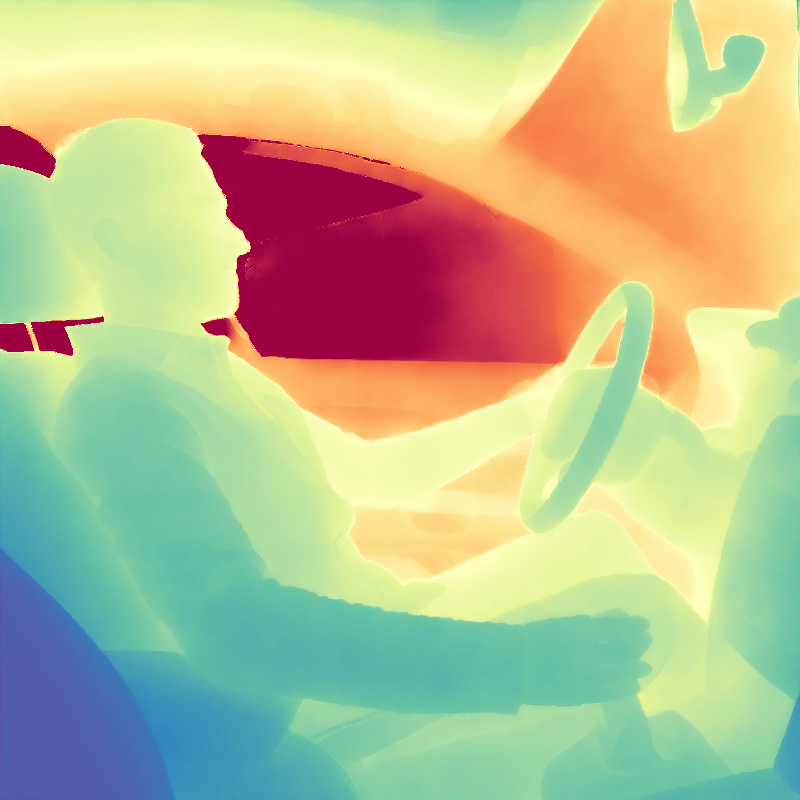

In [52]:
marigold_depth = depth_to_image(normalized, 'logs/marigold_depth.png')
marigold_depth

### MiDaS

In [32]:
MODEL = 'Intel/dpt-hybrid-midas'
pipe = pipeline(task='depth-estimation', model=MODEL, device=0)

In [33]:
image = Image.open(sample_img_path)
res = pipe(image)
depth = res['depth']

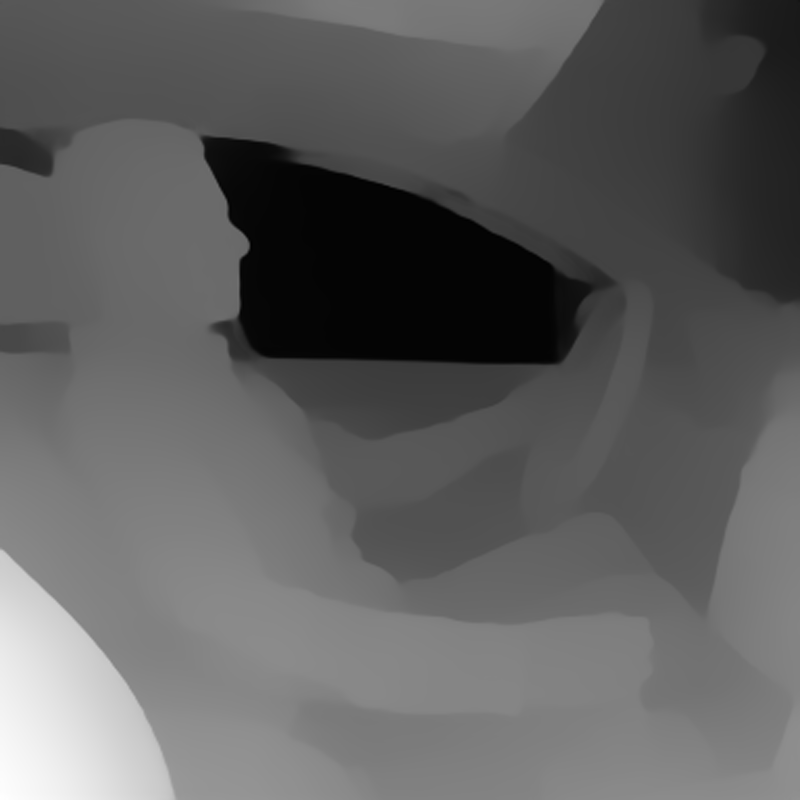

In [34]:
depth

In [35]:
depth.save(output_dir / 'midas_depth_bw.jpg')

Image saved to logs/midas_dpt_depth.png


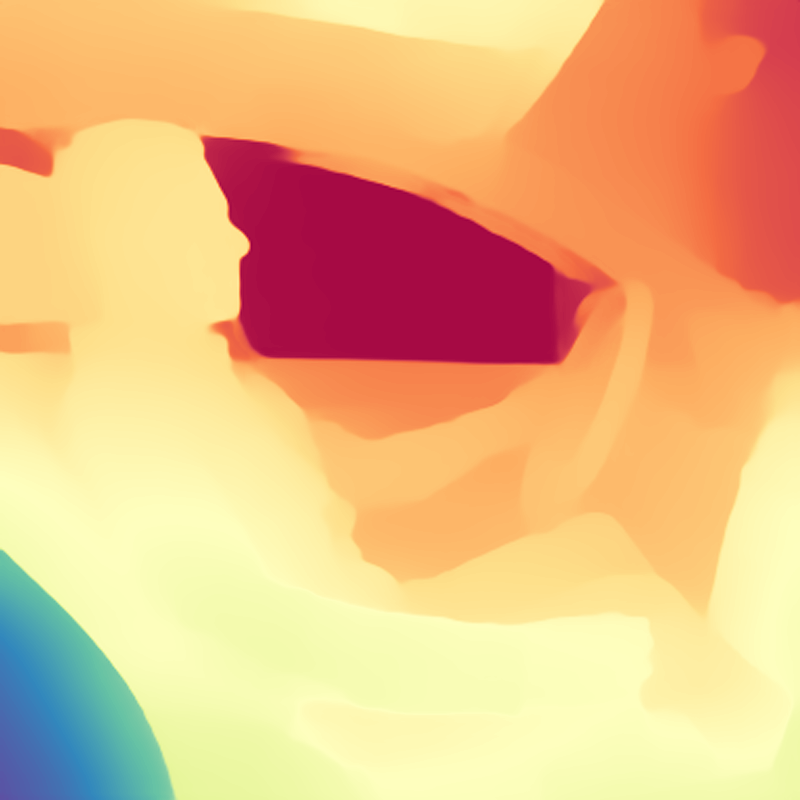

In [36]:
depth_to_image(res['predicted_depth'].numpy(), 'logs/midas_dpt_depth.png')

### Depth Anything 2 Small

In [37]:
MODEL = 'depth-anything/Depth-Anything-V2-Small-hf'
pipe = pipeline(task='depth-estimation', model=MODEL, device=0)

In [38]:
image = Image.open(sample_img_path)
res = pipe(image)
depth = res['depth']

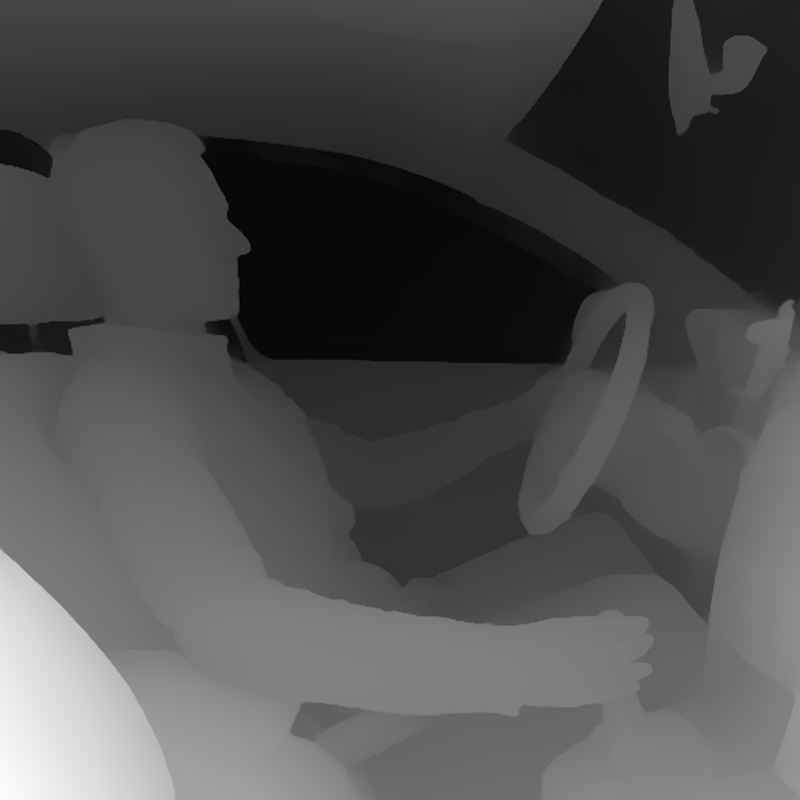

In [39]:
depth

In [40]:
depth.save(output_dir / 'da2s_bw.jpg')

Image saved to logs/depth_anything_2_s_depth.png


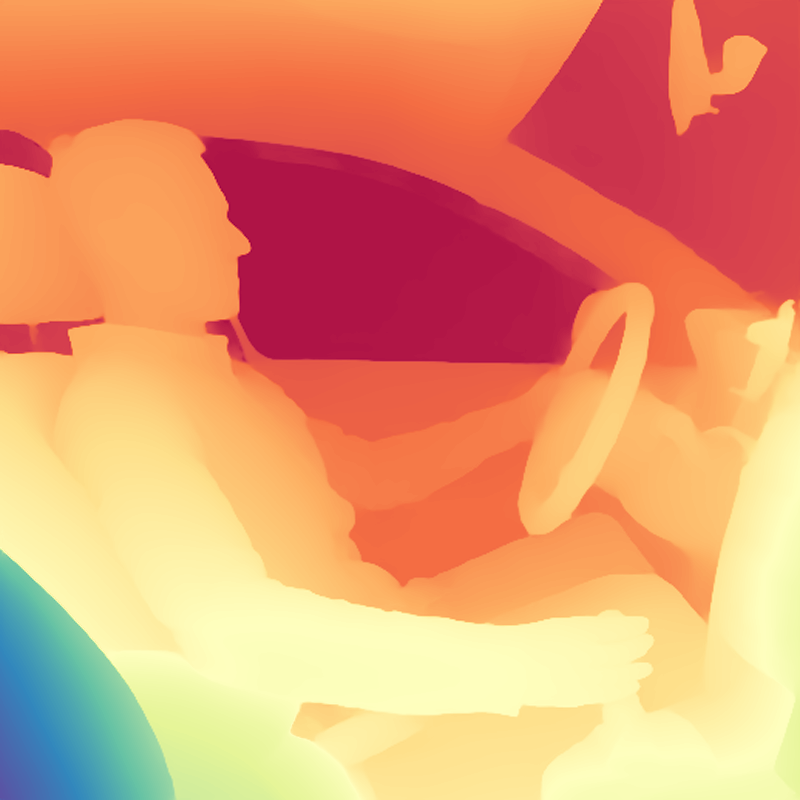

In [41]:
depth_to_image(res['predicted_depth'].numpy(), 'logs/depth_anything_2_s_depth.png')

### Depth Anything 2 Base

In [42]:
MODEL = 'depth-anything/Depth-Anything-V2-Base-hf'
pipe = pipeline(task='depth-estimation', model=MODEL, device=0)

In [43]:
image = Image.open(sample_img_path)
res = pipe(image)
depth = res['depth']

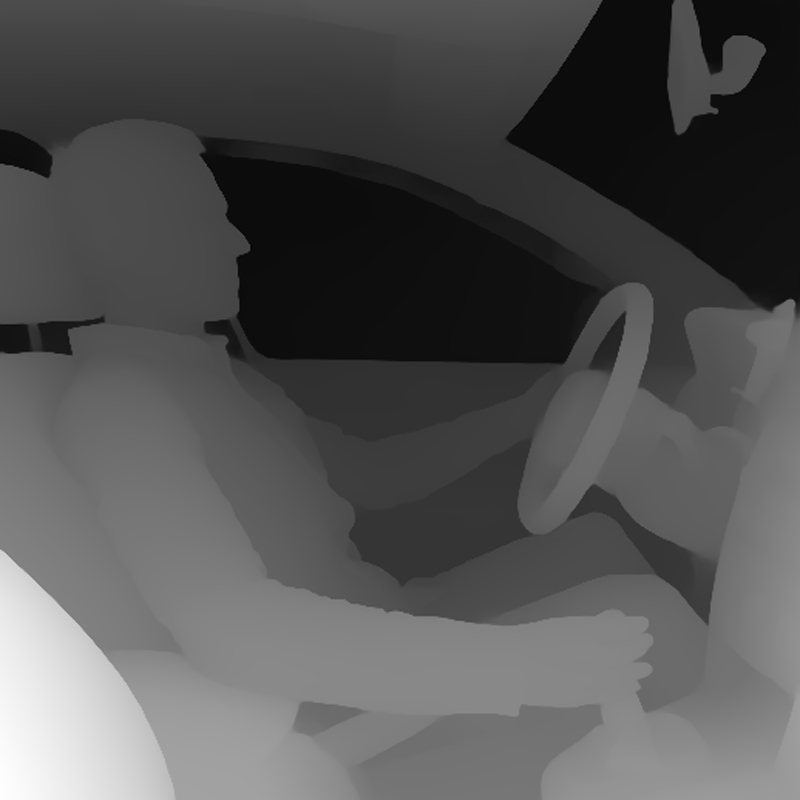

In [44]:
depth

In [45]:
depth.save(output_dir / 'da2b_bw.jpg')

Image saved to logs/depth_anything_2_b_depth.png


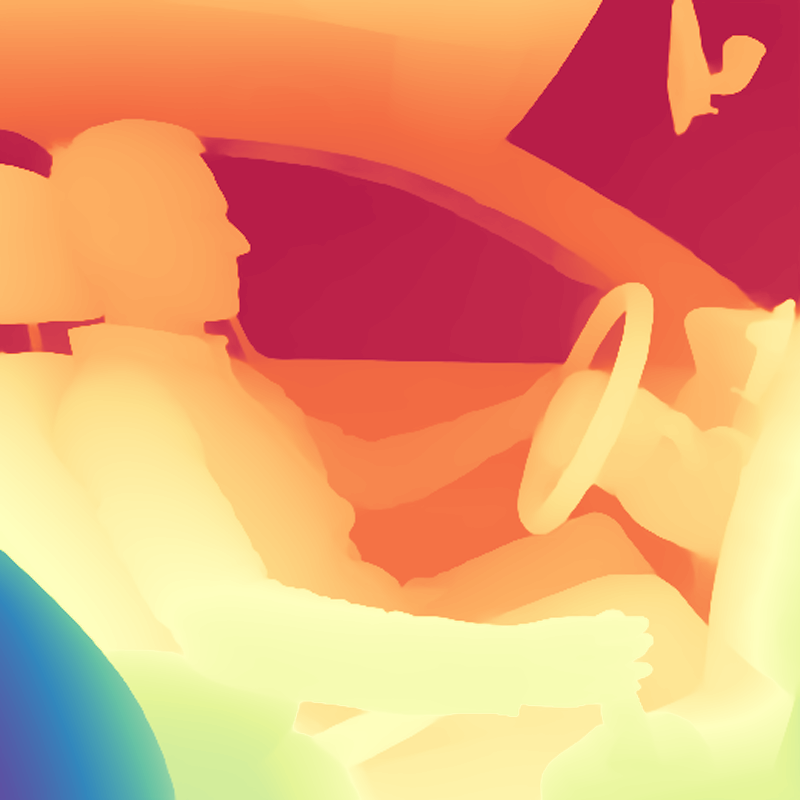

In [46]:
depth_to_image(res['predicted_depth'].numpy(), 'logs/depth_anything_2_b_depth.png')

### Depth Anything 2 Large

In [47]:
MODEL = 'depth-anything/Depth-Anything-V2-Large-hf'
pipe = pipeline(task='depth-estimation', model=MODEL, device=0)

In [48]:
image = Image.open(sample_img_path)
res = pipe(image)
depth = res['depth']

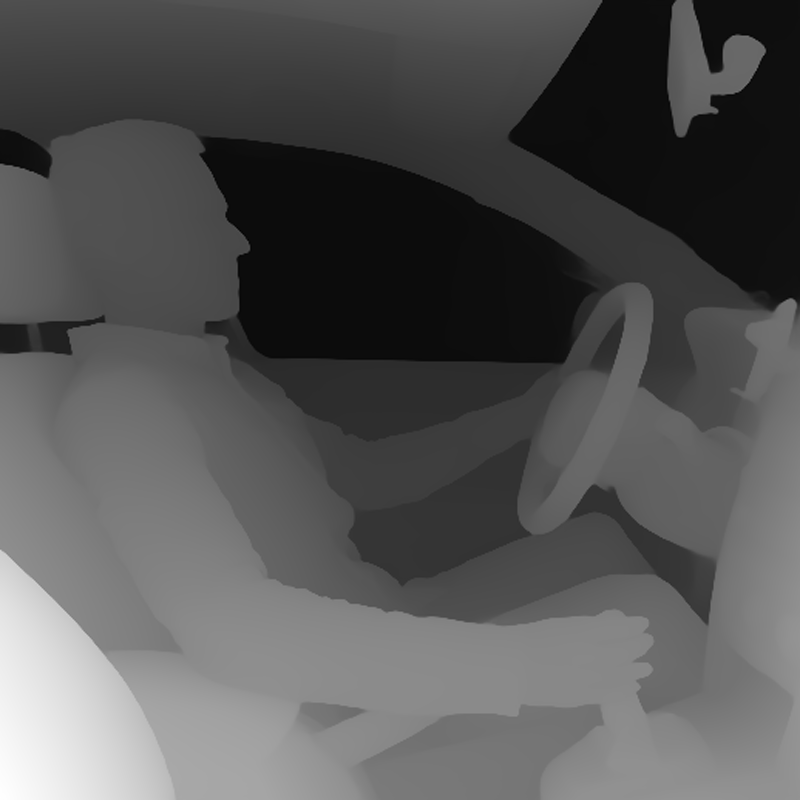

In [49]:
depth

In [50]:
depth.save(output_dir / 'da2l_bw.jpg')

Image saved to logs/depth_anything_2_l_depth.png


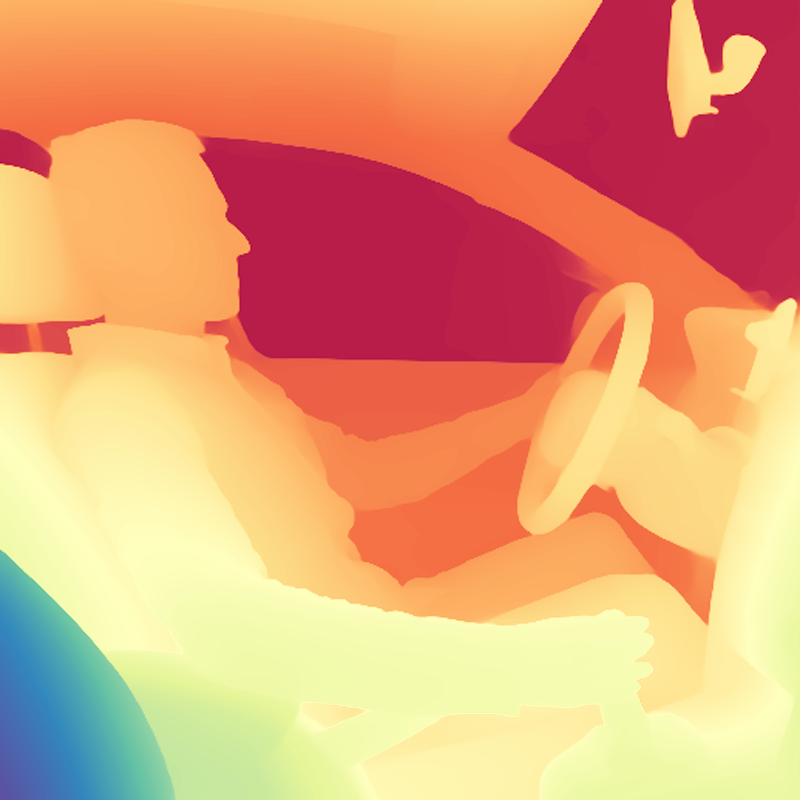

In [51]:
depth_to_image(res['predicted_depth'].numpy(), 'logs/depth_anything_2_l_depth.png')